In [1]:
# Import all necessity functions for Machine Learning
import sys
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import zipfile
import cv2
import os
import random
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, silhouette_score

# Import all necessity functions for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, LSTM, GRU, RNN, Flatten, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Dropout, LeakyReLU, ELU, PReLU
from tensorflow.keras.activations import tanh, relu, sigmoid, softmax, swish
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam, Adamax, Nadam
from tensorflow.keras.initializers import HeNormal, HeUniform, GlorotNormal, GlorotUniform
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, hinge, MSE, MAE, Huber
import keras.utils as image

In [2]:
# Remove all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# To Access the Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# To Unzip the folder
link_folder = '/content/drive/MyDrive/CNN Dataset/malaria-disease-classification.zip'
zip_ref = zipfile.ZipFile(link_folder, 'r')
zip_ref.extractall()
zip_ref.close()

#####Extract the dataset

In [5]:
"""
    1. Create a variable named DIRECTORY there all the images are available
    2. Craete a varibale named FOLDER_NAME there Folder name as label are presenece
    3. Make a path with respect to DIRECTORY & FOLDER_NAME
    4. Iterate over through all images with respect to each Folder
    5. Create variable named STORE_DATA that will append TWO output at a time.

      5.1 First is the data that is extracted from images
      5.2 Second is the label that is extracted through iterate
"""
DIRECTORY = '/content/cell_images/cell_images'
FOLDER_NAME = ['Parasitized', 'Uninfected']
IMAGE_DATA  = []
IMAGE_LABEL = []
STORE_DATA  = []

for folder_name in FOLDER_NAME:
    FULL_PATH = os.path.join(DIRECTORY, folder_name)

    for image_file in os.listdir(FULL_PATH):
        FULL_IMAGE_PATH = os.path.join(FULL_PATH, image_file)

        try:
            # Read the image
            image = cv2.imread(FULL_IMAGE_PATH)
            if image is not None:
                # Make sure that all images would be in the same shape
                resized_image = cv2.resize(image, (80, 80))

                # Store the data and image label for future work
                IMAGE_DATA.append(resized_image)
                IMAGE_LABEL.append(FOLDER_NAME.index(folder_name))

                # Store the extracted data and label into STORE_DATA
                STORE_DATA.append([resized_image, FOLDER_NAME.index(folder_name)])

            else:
                print("Error reading image: {}".format(FULL_IMAGE_PATH))

        except Exception as e:
            print("Error processing image {}: {}".format(FULL_IMAGE_PATH, str(e)))

    print("{} is completed.".format(folder_name))

Error reading image: /content/cell_images/cell_images/Parasitized/Thumbs.db
Parasitized is completed.
Error reading image: /content/cell_images/cell_images/Uninfected/Thumbs.db
Uninfected is completed.


In [6]:
# Display the image dataset with target
print("The total dataset of image # {} ".format(len(IMAGE_DATA)),'\n')
print("The total dataset of label # {} ".format(len(IMAGE_LABEL)))

The total dataset of image # 27558  

The total dataset of label # 27558 


In [7]:
# Shuffle the data to ignore the biasness
try:
  random.shuffle(STORE_DATA)

except Exception as e:
  print(e)
else:
  print('Done')

Done


In [8]:
# Separate the independent and dependent
X = []
y = []

for data, label in STORE_DATA:
  X.append(data)
  y.append(label)

print("Separation is done.\n")

# Convert the independent and dependent into NumPy array
X = np.array(X)
y = np.array(y)

print("Conversion is done.")

Separation is done.

Conversion is done.


In [9]:
# Display the shape of Train and Test
print("Train shape # {} ".format(X.shape),'\n')
print("Test shape  # {} ".format(y.shape))

Train shape # (27558, 80, 80, 3)  

Test shape  # (27558,) 


In [10]:
# To prevent the memory issue take 20000 dataset
MIN = 0
MAX = 20000

X = X[MIN: MAX]
y = y[MIN: MAX]

# Display the shape of Train and Test
print("Train shape # {} ".format(X.shape),'\n')
print("Test shape  # {} ".format(y.shape))

Train shape # (20000, 80, 80, 3)  

Test shape  # (20000,) 


#####Display some of the dataset

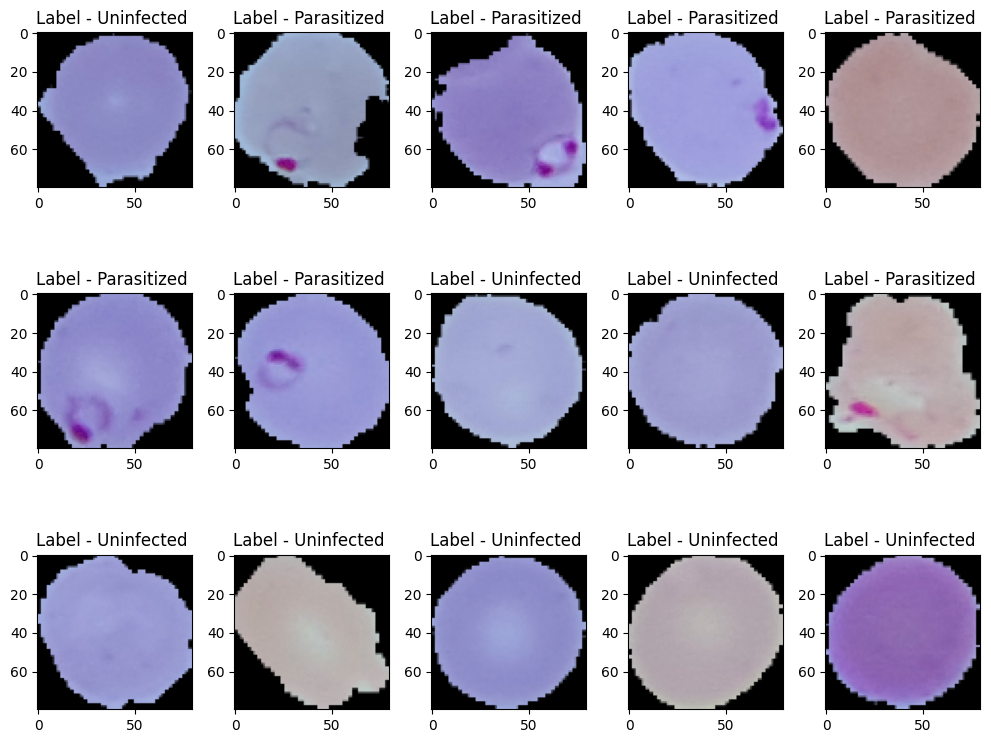

In [11]:
"""
    Take the random 15 data and label from X and y
"""
plt.figure(figsize = (10, 8))

# Take the 15 items from the label
labels = y[0:15]

# Take the 15 itens from the train data
for index, images in enumerate(X[0:15]):
  plt.subplot(3, 5, index + 1)
  plt.title('Label - {} '.format('Parasitized' if labels[index] == 0 else 'Uninfected'))
  plt.imshow(images)

plt.tight_layout()
plt.show()

#####Normalized the data

In [12]:
# Normalization the image dataset
X = X/255

print("Normalization is completed.".capitalize())

Normalization is completed.


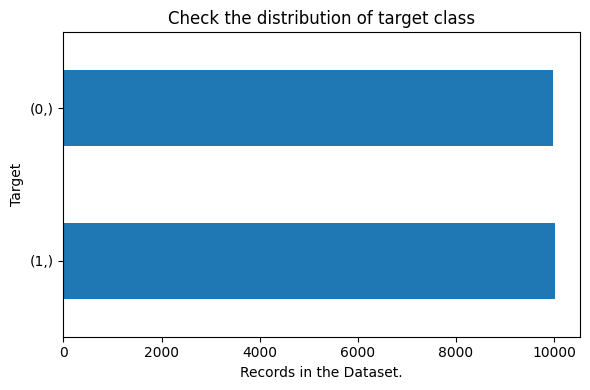

In [13]:
# Check the data is imbalanced or not
plt.figure(figsize = (6, 4))
plt.title('Check the distribution of target class'.capitalize())
pd.DataFrame(y, columns = ['Target']).value_counts().plot(kind = 'barh')
plt.xlabel('Records in the Dataset.')
plt.tight_layout()
plt.show()

#####Call the DataLoader with batch_size: 128

In [14]:
# Import all the necessity function with PyTorch
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [15]:
"""
    X shape was: (20000, 80, 80, 3)
    X shape is : (20000, 3, 80, 80)
"""
# Initialize the batch_size
BATCH_SIZE = 128

# Reshaping the dataset of Train
X = X.reshape(-1, 3, 80, 80)

# Convert the Data type into Float with respect to torch
X = torch.tensor(data = X, dtype = torch.float32)
y = torch.tensor(data = y, dtype = torch.float32)

# Split the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                                    test_size = 0.30,\
                                                    random_state = 42)

# Display the shape
print("X_train shape # {} ".format(X_train.shape),'\n')
print("y_train shape # {} ".format(y_train.shape),'\n')
print("X_test shape  # {} ".format(X_test.shape),'\n')
print("y_test shape  # {} ".format(y_test.shape),'\n'*2)

# Call the DataLoader
TRAIN_LOADER = DataLoader(dataset    = list(zip(X_train, y_train)),\
                          batch_size = BATCH_SIZE,\
                          shuffle    = True)

TEST_LOADER  = DataLoader(dataset    = list(zip(X_test, y_test)),\
                          batch_size = BATCH_SIZE,\
                          shuffle    = True)

# Display the batch_size
print("Train batch_size # {} ".format(TRAIN_LOADER.batch_size),'\n')
print("Test batch_size  # {} ".format(TEST_LOADER.batch_size),'\n'*2)

# Separate the data and label
train_data, train_label = next(iter(TRAIN_LOADER))
test_data , test_label  = next(iter(TEST_LOADER))

# Display the shape
print("Train data with batch_size shape  # {} ".format(train_data.shape),'\n')
print("Train label with batch_size shape # {} ".format(train_label.shape),'\n'*2)

print("Test data with batch_size shape   # {} ".format(test_data.shape),'\n')
print("Test label with batch_size shape  # {} ".format(test_label.shape))

X_train shape # torch.Size([14000, 3, 80, 80])  

y_train shape # torch.Size([14000])  

X_test shape  # torch.Size([6000, 3, 80, 80])  

y_test shape  # torch.Size([6000])  


Train batch_size # 128  

Test batch_size  # 128  


Train data with batch_size shape  # torch.Size([128, 3, 80, 80])  

Train label with batch_size shape # torch.Size([128])  


Test data with batch_size shape   # torch.Size([128, 3, 80, 80])  

Test label with batch_size shape  # torch.Size([128]) 


#####Initialize the model checkpoint

In [16]:
"""
    Define the checkpoint function that will take TWO parameters
      1. model : Define the model
      2. filename : Define .pth file there all the weights and bias would be stored
"""
def checkpoint(model = None, filename = None):
  try:
    torch.save(model.state_dict(), filename)

  except Exception as e:
    print(e.with_traceback())

"""
    Define the resume function that will take TWO parameters
      1. model : Define the model
      2.filename : Define .pth file there all the weights and bias would be stored
"""

def resume(model = None, filename = None):
  try:
    model.load_state_dict(torch.load(filename))

  except Exception as e:
    print(e.with_traceback())

#####Model building

In [17]:
"""
    Define a class named TyphoidClassifier that would take TWO parameters
      1. input_channel : Define whether the Image is RGB or Gray. 1 - means RGB and 0 - means Gray
      2. output_dimension : Define whether it is binary or multi classification task

    Call the super method that will inherit all the necessity methods and functions of PyTorch
    Create the multiple Convolutional Layer to extract the feature map
"""
# Initialize the DROPOUT_RATE = 0.3
DROPOUT_RATE = 0.3

class TyphoidClassifier(nn.Module):
  def __init__(self, input_channel = None, output_dimension = None):
    super().__init__()

    """
        Create a sequential model named Convolution1 that would take a couple of parameters
          1. in_channels : Define the input_channel - this would be 3
          2. out_channels: Define the output neurons that would be 128 in this case
          3. kernel_size : Define the kernel/filters that would be placed on top of images to extract the feature map
          4. stride      : Define how much the kernel/filter would be moved (TOP/BOTTOM/LEFT/RIGHT)
          5. padding     : padding is used to make sure the extrcated feature map is equivalent to the orginal.

        Activation     : ReLU - This would define next neurons would be activated or not and transfer the data or not as well
        Pooling Layer  : Pooling is used to do the downsampling the feature map so that training would be faster and prevent overfitting
        Dropout-rate   : Prevent the overfitting problem and rate of p would be 0.3

        Input-Shape: (80 * 80) * 3
    """
    self.Convolution1 = nn.Sequential(
        nn.Conv2d(in_channels = input_channel,\
                  out_channels = 128,\
                  kernel_size = 3,\
                  stride = 1,\
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,\
                     stride = 2),
        nn.Dropout(p = DROPOUT_RATE)
    )

    """
        Create second sequential model named Convolution1 that would take a couple of parameters
          1. in_channels : Define the input_channel - this would be 3
          2. out_channels: Define the output neurons that would be 64 in this case
          3. kernel_size : Define the kernel/filters that would be placed on top of images to extract the feature map
          4. stride      : Define how much the kernel/filter would be moved (TOP/BOTTOM/LEFT/RIGHT)
          5. padding     : padding is used to make sure the extrcated feature map is equivalent to the orginal.

        Activation : ReLU - This would define next neurons would be activated or not and transfer the data or not as well
        Pooling Layer : Pooling is used to do the downsampling the feature map so that training would be faster and prevent overfitting
        Dropout-rate  : Prevent the overfitting problem and rate of p would be 0.3

        Input-Shape: (40 * 40) * 128
    """
    self.Convolution2 = nn.Sequential(
        nn.Conv2d(in_channels = 128,\
                  out_channels = 64,\
                  kernel_size = 3,\
                  stride = 1,\
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,\
                     stride = 2),
        nn.Dropout(p = DROPOUT_RATE)
    )
    """
        Create third sequential model named Convolution1 that would take a couple of parameters
          1. in_channels : Define the input_channel - this would be 3
          2. out_channels: Define the output neurons that would be 32 in this case
          3. kernel_size : Define the kernel/filters that would be placed on top of images to extract the feature map
          4. stride      : Define how much the kernel/filter would be moved (TOP/BOTTOM/LEFT/RIGHT)
          5. padding     : padding is used to make sure the extrcated feature map is equivalent to the orginal.

        Activation     : ReLU - This would define next neurons would be activated or not and transfer the data or not as well
        Pooling Layer  : Pooling is used to do the downsampling the feature map so that training would be faster and prevent overfitting
        Dropout-rate   : Prevent the overfitting problem and rate of p would be 0.3

        Input-Shape: (20 * 20) * 64
    """
    self.Convolution3 = nn.Sequential(
        nn.Conv2d(in_channels = 64,\
                  out_channels = 32,\
                  kernel_size = 3,\
                  stride = 1,\
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,\
                     stride = 2)
    )

    """
        Input-Shape: (10 * 10) * 32
        Create a Sequential model that would take a couple of parameters
          1. in_features: 10 * 10 * 32
          2. out_features : 256
          3. Actiaction : ReLU
          4. Dropout-Rate : 0.3
    """
    self.fc1 = nn.Sequential(
        nn.Linear(in_features = 10 * 10 * 32, out_features = 256),
        nn.ReLU(),
        nn.Dropout(p = DROPOUT_RATE)
    )

    """
        Create second Sequential model that would take a couple of parameters
          1. in_features: 256
          2. out_features : 128
          3. Actiaction : ReLU
          4. Dropout-Rate : 0.3
    """
    self.fc2 = nn.Sequential(
        nn.Linear(in_features = 256, out_features = 128),
        nn.ReLU(),
        nn.Dropout(p = DROPOUT_RATE)
    )

    """
        Create third Sequential model that would take a couple of parameters
          1. in_features: 128
          2. out_features : 64
          3. Actiaction : ReLU
          4. Dropout-Rate : 0.5
    """
    self.fc3 = nn.Sequential(
        nn.Linear(in_features = 128, out_features = 64),
        nn.ReLU(),
        nn.Dropout(p = 0.5)
    )

    """
        Create an output Layer that would take
          1. in_features : 64
          2. out_features : 2
          3. Activation : Softmax
    """
    self.outLayer = nn.Sequential(
        nn.Linear(in_features = 64, out_features = output_dimension),
        nn.Softmax()
    )

  def forward(self, x):
    """
        For the First Convolutional Layer
    """
    x = self.Convolution1(x)

    """
        For the Second Convolutional Layer
    """
    x = self.Convolution2(x)

    """
        For the Third Convolutional Layer
    """
    x = self.Convolution3(x)

    """
        For the Flatten Layer
    """
    x = x.reshape(x.shape[0], -1)

    """
        For the First Hidden Layer
    """
    x = self.fc1(x)

    """
      For the Second Hidden Layer
    """
    x = self.fc2(x)

    """
        For the Third Hidden Layer
    """
    x = self.fc3(x)

    """
        For the Output Layer
    """
    x = self.outLayer(x)

    return x

In [18]:
# Call the model
try:
  model = TyphoidClassifier(input_channel = 3, output_dimension = 2)

except Exception as e:
  print(e.with_traceback())
else:
  print(model.parameters)

<bound method Module.parameters of TyphoidClassifier(
  (Convolution1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (Convolution2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (Convolution3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3200, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(

# GPU connect

In [19]:
# GPU connect
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
# GPU connect to the model
model = model.to(device)

# Display the summary
summary(model = model, input_size = X_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 80, 80]           3,584
              ReLU-2          [-1, 128, 80, 80]               0
         MaxPool2d-3          [-1, 128, 40, 40]               0
           Dropout-4          [-1, 128, 40, 40]               0
            Conv2d-5           [-1, 64, 40, 40]          73,792
              ReLU-6           [-1, 64, 40, 40]               0
         MaxPool2d-7           [-1, 64, 20, 20]               0
           Dropout-8           [-1, 64, 20, 20]               0
            Conv2d-9           [-1, 32, 20, 20]          18,464
             ReLU-10           [-1, 32, 20, 20]               0
        MaxPool2d-11           [-1, 32, 10, 10]               0
           Linear-12                  [-1, 256]         819,456
             ReLU-13                  [-1, 256]               0
          Dropout-14                  [

#####Initialize loss and optimizer

In [21]:
# Initialize the learning_rate
LEARNING_RATE = 0.001

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(params = model.parameters(), lr = LEARNING_RATE)

#####Train the model

In [22]:
"""
    Create a class named Fit and default constructor
      1. EPOCHS: Define how many times the code would be executed
      2. TRAIN_LOSS: Define the train loss during the training
      3. VAL_LOSS: Define the validation or test loss during training and testing with respect to model
      4. TRAIN_ACC: Define the train accuracy that is computed during training
      5. VAL_ACC: Define the validation accuracy that is computed during training and testing
      6. BATCH_SIZE: Define the batch_size that is passed at a time to train the model and update the weights and bias

    Create a method named fit that will take a couple of parameters
      1. model: Define the model
      2. epochs: Define the epoch size that would be provided by users
      3. batch_size : Define the batch_size which is used to train the model and assist to upadte the weights and bias
      4. x: X_train - training dataset
      5. y: y_train - trainung dataset
      6. val_data: X_test - testing data
      7. val_label: y_test - testing data as a label
      8. verbose: 1 means display each iteration and epoch loss and accuracy
"""
class Fit:
  def __init__(self):
    self.EPOCHS     = -1
    self.TRAIN_LOSS = []
    self.VAL_LOSS   = []
    self.TRAIN_ACC  = []
    self.VAL_LOSS   = []
    self.BATCH_SIZE = 32
    self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

  ############################
  #      Regularization      #
  ############################
  """
      Define the L1 regularization that would prevent the overfitting problem
      Formula of L1 regularization : loss + l1_lamba * |weight|
  """
  def l1(self, model = None, l1_lambda = 0.01):
    return sum(torch.norm(parameter, 1) for parameter in model.parameters())

  """
      Define the L2 regularization that would prevent the overfitting problem
      Formula of L2 regularization : loss + l2_lamba * weight * weight
  """
  def l2(self, model = None, l2_lambda = 0.01):
    return sum(torch.norm(parameter, 2) for parameter in model.parameters())

  ###########################
  #           Fit           #
  ###########################

  def fit(self, model = None, X = None, y = None, epochs = None, batch_size = None, val_data = None, val_label = None, verbose = 1):
    """
        Store the Epoch and batch_size in the varibales
        Convert the train and test dataset into Float that is accepted for PyTorch
        Create the DataLoader with respect to train and test
    """
    self.EPOCHS = epochs
    self.BATCH_SIZE = batch_size

    X = torch.tensor(data = X, dtype = torch.float32)
    y = torch.tensor(data = y, dtype = torch.float32)

    val_data  = torch.tensor(data = val_data, dtype = torch.float32)
    val_label = torch.tensor(data = val_label, dtype = torch.float32)

    train_loader = DataLoader(dataset = list(zip(X, y)), batch_size = self.BATCH_SIZE, shuffle = True)
    test_loader  = DataLoader(dataset = list(zip(val_data, val_label)), batch_size = self.BATCH_SIZE, shuffle = True)

    ###########################
    #        Training         #
    ###########################

    model.train()

    """
        1. Run a loop with respect to EPOCH

        2. Initialize a couple of variables that would be necessary
          2.1 total_train_loss : Define the total train loss during training
          2.2 total_val_loss : Define the total validation loss during testing
          2.3 train_predictions : Define the train_predictions after completed each EPOCH
          2.4 val_predictions : Define the validation predictions after completed each EPOCH
          2.5 train_labels : Define the total train labels in each EPOCH
          2.6 val_labels : Define the total validation labels in each EPOCH

       3. Run a loop with respect to train_loader and extract the data and labels

       4. Pass the data into the defined model and do the predictions

       5. Calculate the loss function
    """
    for epoch in range(self.EPOCHS):
      total_train_loss  = []
      total_val_loss    = []
      train_predictions = []
      val_predictions   = []
      train_labels      = []
      val_labels        = []

      for (X_batch, y_batch) in train_loader:
        """
            1. Connect the X_batch and y_batch into GPU so that we can make the training faster
            2. Initialize the optimizer
            3. Do back propagation with respect to train_loss
            4. Do step operation with respect to optimizer
        """
        X_batch = X_batch.to(device)
        y_batch = y_batch.long()
        y_batch = y_batch.to(device)

        # Do the prediction
        train_prediction = model(X_batch)
        # Compute the loss function
        train_loss = loss_function(train_prediction, y_batch)

        # Initialize the optimizer
        optimizer.zero_grad()
        # Do back-propagation with respect to train_loss
        train_loss.backward()
        # Do the step operation with respect to optimier
        optimizer.step()

        # Store the train predictions into the train_predictions list
        train_predictions.extend(torch.argmax(train_prediction.cpu(), 1).flatten().detach().numpy())
        # Store the train labels orginal into train_labels
        train_labels.extend(y_batch.cpu().flatten().detach().numpy())
        # Store the train loss into total_train_loss
        total_train_loss.append(train_loss.item())

      ###########################
      #    Evaluation Train     #
      ###########################
      train_accuracy = accuracy_score(train_labels, train_predictions)

      # Store the accuracy and loss into the history
      self.history['accuracy'].append(train_accuracy)
      self.history['loss'].append(np.array(total_train_loss).mean())

      ############################
      #         Testing          #
      ############################

      model.eval()

      for (val_data, val_label) in test_loader:
        val_label = val_label.long()
        val_label = val_label.to(device)
        val_data  = val_data.to(device)

        # Compute the validation prediction
        val_prediction = model(val_data)
        # Compute the validation loss
        val_loss = loss_function(val_prediction, val_label)

        # Store the validation predictions into val_predictions
        val_predictions.extend(torch.argmax(val_prediction.cpu(), 1).flatten().detach().numpy())
        # Store the validation labels into val_labels
        val_labels.extend(val_label.cpu().flatten().detach().numpy())
        # Store the validation loss into total_val_loss
        total_val_loss.append(val_loss.item())

      ############################
      #      Compute Testing     #
      ############################

      val_accuracy = accuracy_score(val_labels, val_predictions)

      # Store the val_accuracy and val_loss into the history
      self.history['val_accuracy'].append(val_accuracy)
      self.history['val_loss'].append(np.array(total_val_loss).mean())

      print("Epoch {}/{} ".format(epoch + 1, self.EPOCHS))

      print("{}/{} [=========================] loss: {} - accuracy: {} - val_loss: {} - val_accuracy: {}".format(train_loader.batch_size,\
                                                                                                                test_loader.batch_size,\
                                                                                                                np.array(total_train_loss).mean(),\
                                                                                                                train_accuracy,\
                                                                                                                np.array(total_val_loss).mean(),\
                                                                                                                val_accuracy))


In [23]:
# Call the model with this current directory
try:
  model_fit = Fit()

except Exception as e:
  print(e.with_traceback())
else:
  model_fit.fit(model = model,\
                X = X_train,\
                y = y_train,\
                epochs = 50,\
                batch_size = 128,\
                val_data = X_test,\
                val_label = y_test,\
                verbose = 1)

Epoch 1/50 
128/128 [=========================] loss: 0.6852173599329862 - accuracy: 0.5433571428571429 - val_loss: 0.6645157197688488 - val_accuracy: 0.617
Epoch 2/50 
128/128 [=========================] loss: 0.639536837014285 - accuracy: 0.6368571428571429 - val_loss: 0.6206266588353097 - val_accuracy: 0.6633333333333333
Epoch 3/50 
128/128 [=========================] loss: 0.6082186915657737 - accuracy: 0.6797857142857143 - val_loss: 0.5899489598071321 - val_accuracy: 0.7066666666666667
Epoch 4/50 
128/128 [=========================] loss: 0.5849084377288818 - accuracy: 0.7111428571428572 - val_loss: 0.5764683085553189 - val_accuracy: 0.7233333333333334
Epoch 5/50 
128/128 [=========================] loss: 0.5562922098419883 - accuracy: 0.745 - val_loss: 0.559692288966889 - val_accuracy: 0.7426666666666667
Epoch 6/50 
128/128 [=========================] loss: 0.5503580938686025 - accuracy: 0.7505714285714286 - val_loss: 0.5805497169494629 - val_accuracy: 0.7063333333333334
Epoch 7/

#####Display the loss & accuracy

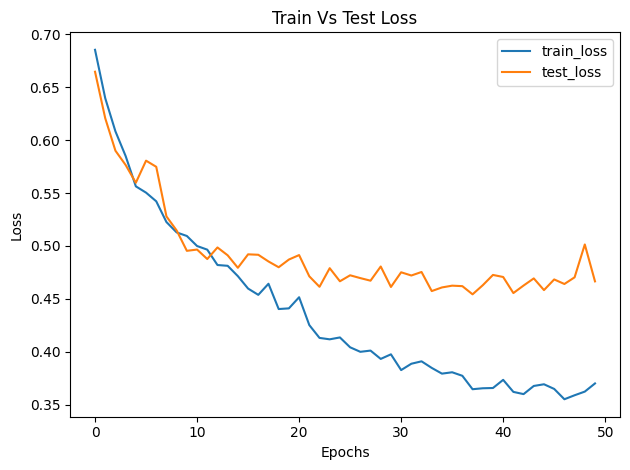

In [24]:
plt.plot(model_fit.history['loss'], label = 'train_loss')
plt.plot(model_fit.history['val_loss'], label = 'test_loss')
plt.title('Train Vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

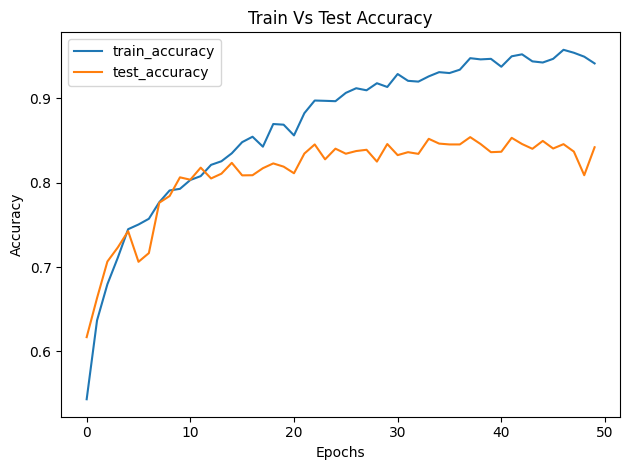

In [25]:
plt.plot(model_fit.history['accuracy'], label = 'train_accuracy')
plt.plot(model_fit.history['val_accuracy'], label = 'test_accuracy')
plt.title('Train Vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#####Do the evaluation

In [26]:
##########################
#       Training         #
##########################
train_labels   = []
train_predicts = []

for train_data, train_label in TRAIN_LOADER:
  """
      Conncet the GPU
  """
  train_data  = train_data.to(device)
  train_label = train_label.long()
  train_label = train_label.to(device)

  predicted = model(train_data)

  train_predicts.extend(torch.argmax(predicted.cpu(), 1).flatten().detach().numpy())
  train_labels.extend(train_label.cpu().flatten().detach().numpy())

print("accuracy  # {} ".upper().format(accuracy_score(train_labels, train_predicts)),'\n')
print("precision # {} ".upper().format(precision_score(train_labels, train_predicts, average = 'macro')),'\n')
print("recall    # {} ".upper().format(recall_score(train_labels, train_predicts, average = 'macro')),'\n')
print("f1_score  # {} ".upper().format(f1_score(train_labels, train_predicts, average = 'macro')))

ACCURACY  # 0.9599285714285715  

PRECISION # 0.9600522644267311  

RECALL    # 0.9598985012331626  

F1_SCORE  # 0.9599234021608675 


In [27]:
##########################
#        Testing         #
##########################

test_labels   = []
test_predicts = []

for test_data, test_label in TEST_LOADER:
  """
      Conncet the GPU
  """
  test_data  = train_data.to(device)
  test_label = train_label.long()
  test_label = train_label.to(device)

  predicted = model(test_data)

  test_predicts.extend(torch.argmax(predicted.cpu(), 1).flatten().detach().numpy())
  test_labels.extend(test_label.cpu().flatten().detach().numpy())

print("accuracy  # {} ".upper().format(accuracy_score(test_labels, test_predicts)),'\n')
print("precision # {} ".upper().format(precision_score(test_labels, test_predicts, average = 'macro')),'\n')
print("recall    # {} ".upper().format(recall_score(test_labels, test_predicts, average = 'macro')),'\n')
print("f1_score  # {} ".upper().format(f1_score(test_labels, test_predicts, average = 'macro')))

ACCURACY  # 0.9583333333333334  

PRECISION # 0.9582608695652174  

RECALL    # 0.9582608695652174  

F1_SCORE  # 0.9582608695652174 


#####Check the performance

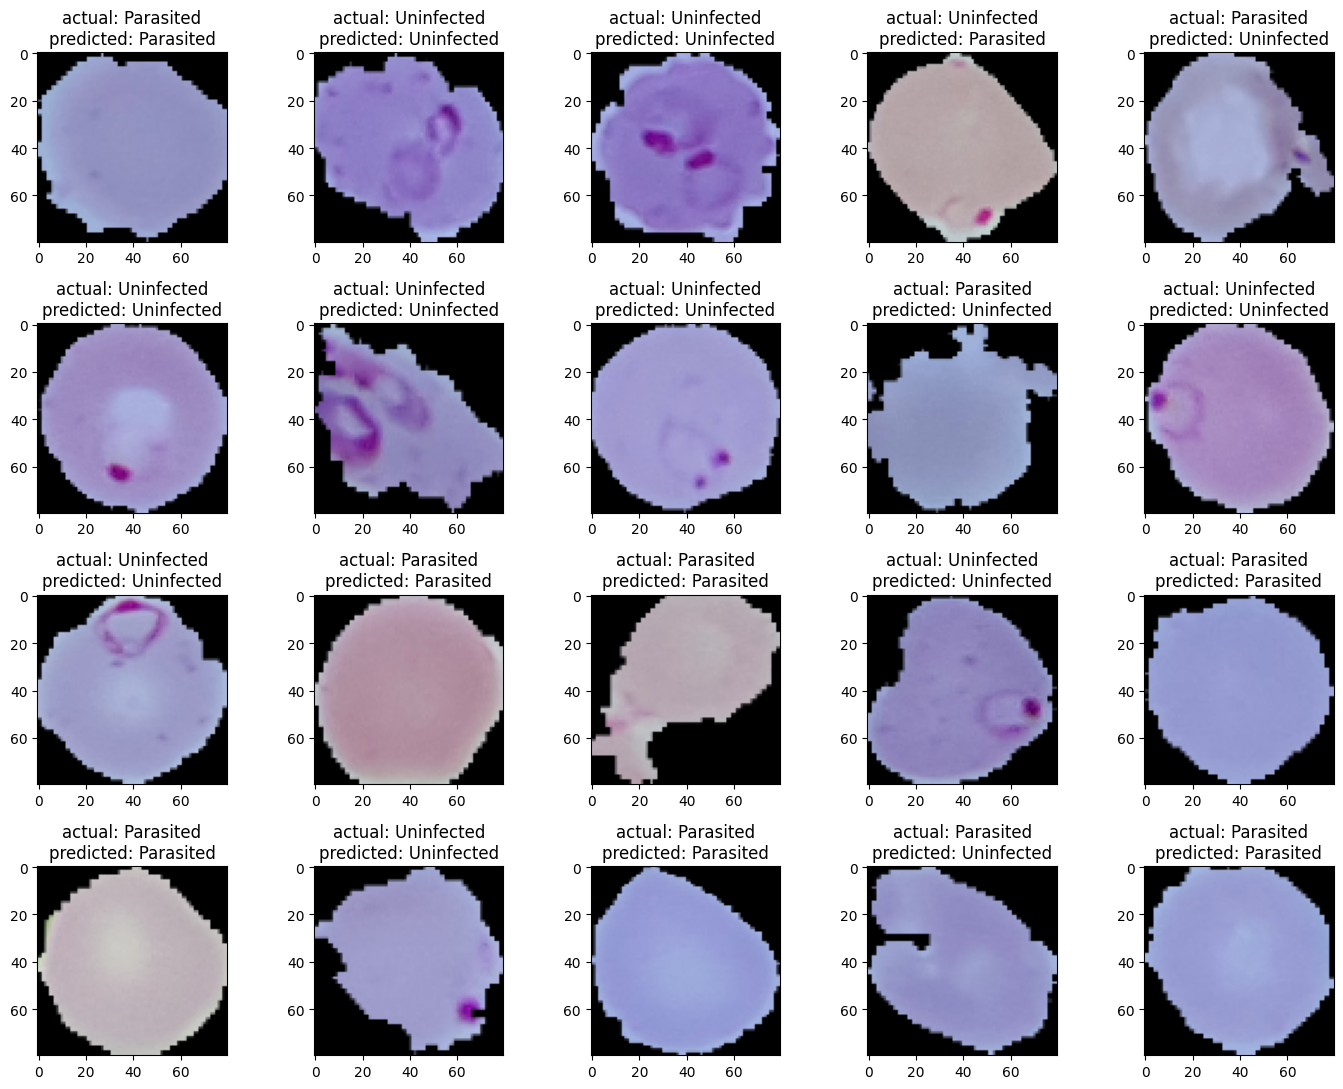

In [117]:
"""
    Initialize the list
    image_data: Define the image data
    label_data: Define the label with respect to image
"""
image_data = []
label_data = []

for data, label in TEST_LOADER:
  image_data.append(data.reshape(-1, 80, 80, 3))
  label_data.append(label)
  break

# Connect GPU to the image_data & label_data
X_check = image_data[0].to(device)
label_data = label_data[0].long()
label_data = label_data.to(device)

"""
    Compute the prediction and store the actual value into the list
"""
X_check   = X_check.reshape(-1, 3, 80, 80)
predicted = model(X_check)
predicted = torch.argmax(predicted.cpu(), 1).flatten().detach().numpy()
actual_label = label_data.cpu().flatten().detach().numpy()

######################
#      Display       #
######################

plt.figure(figsize = (14, 11))
for index, image in enumerate(image_data[0][0:20]):
  plt.subplot(4, 5, index + 1)
  plt.title('actual: {}\npredicted: {}'.format('Parasited' if actual_label[index] else 'Uninfected',\
                                               'Parasited' if predicted[index] else 'Uninfected'))
  plt.imshow(image)

plt.tight_layout()
plt.show()